<a href="https://colab.research.google.com/github/CrMessiSuriJr/Plant_disease_detection/blob/main/InceptionNetV3_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @markdown Installing required files/libraries and updating previously intsalled
!pip install --upgrade torch torchvision Pillow matplotlib scikit-image scikit-learn
!pip install captum lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 27.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b93523d75012d17d4da0277ce2f8f5c8b10bc4205f7bfe64d0ea4756ec726990
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# @markdown Importing libraries: torch, os, random, shutil, google.colab, PIL, matplotlib, Install & Import captum etc...
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import datasets, models
import os
import numpy as np
import random
import shutil
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt

import captum.attr as captum_attr
from captum.attr import GuidedGradCam

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from lime.lime_image import LimeImageExplainer

from sklearn.manifold import TSNE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define data preprocessing and augmentation
# @markdown Keep the dim to atleast 299, as the inception net v3 model expects atleast a dimension of 299 as per torchvison docs and torch.hub implementation
dim = 299 # @param {type:"integer"}
# @markdown Keeping the dim to 384 by default for safety
crop_dim = 299 # @param {type:"integer"}
norm_mean = [0.0]*3
norm_std = [0.0]*3
norm_mean[0] = 0.485 # @param
norm_mean[1] = 0.456 # @param
norm_mean[2] = 0.406 # @param
norm_std[0] = 0.229 # @param
norm_std[1] = 0.224 # @param
norm_std[2] = 0.225 # @param
transform = transforms.Compose([
    transforms.Resize((dim, dim)),  # Resize images to a fixed size
    transforms.CenterCrop(crop_dim),     # Center crop to 224x224 pixels
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize(mean=norm_mean, std=norm_std)  # Normalize
])


In [ ]:
drive.mount('/content/drive')

# @markdown Set the path to your Kaggle API key in Google Drive
kaggle_api_key_path = "/content/drive/MyDrive/.kaggle/kaggle.json" # @param {type:"string"}
# @markdown ^^^The folder containing kaggle.json api file, in Google-drive for file persistence

# @markdown Copy the Kaggle API key to the required directory
!mkdir -p ~/.kaggle
!cp "$kaggle_api_key_path" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Mounted at /content/drive


In [ ]:
# @markdown Importing kaggle for api access for dataset download
import kaggle

# @markdown Replace 'your_dataset_folder' with the Kaggle dataset name
dataset_name = 'emmarex/plantdisease' # @param {type:"string"}

# @markdown Define the dataset path
dataset_path = '/content' # @param {type:"string"}

# @markdown Download the dataset using Kaggle API
to_download_data = True # @param {type:"boolean"}
if (to_download_data): kaggle.api.dataset_download_files(dataset_name, unzip=True, path = dataset_path)  # Download and unzip the dataset to the './data' directory



In [ ]:
# @markdown Define the ratio for the train-test split\
# @markdown By Deafult: 70% for training, 30% for testing
split_ratio = 0.85 # @param {type:"slider", min:0, max:1, step:0.01}

# @markdown Specify the path to your dataset on Google Drive
drive_dataset_path = '/PlantVillage' # @param {type:"string"}
drive_dataset_path = dataset_path + drive_dataset_path

# @markdown List all the class folders in your dataset directory
class_folders = os.listdir(drive_dataset_path)

# @markdown Create train and test directories if they don't exist
base_dir = dataset_path # @param {type:"string"}

train_dir = base_dir + "/train" # @markdown train_dir = base_dir + "/train"

test_dir = base_dir + "/test" # @markdown test_dir = base_dir + "/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# @markdown Function to check if an image can be opened without errors
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except Exception as e:
        return False

# @markdown Iterate through each class folder
for class_folder in class_folders:
    class_path = os.path.join(drive_dataset_path, class_folder)

    # @markdown List all the image files in the current class folder
    all_files = os.listdir(class_path)

    # @markdown Randomly shuffle the list of files
    random.shuffle(all_files)

    # @markdown Calculate the number of files for training and testing within the current class
    num_total_files = len(all_files)
    num_train_files = int(split_ratio * num_total_files)
    num_test_files = num_total_files - num_train_files

    # @markdown Create train and test subdirectories within the class folder
    class_train_dir = os.path.join(train_dir, class_folder)
    class_test_dir = os.path.join(test_dir, class_folder)
    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_test_dir, exist_ok=True)

    # @markdown Move the first num_train_files files to the train subdirectory and the rest to the test subdirectory
    for i, file_name in enumerate(all_files):
        source_path = os.path.join(class_path, file_name)
        if i < num_train_files and is_valid_image(source_path):
            destination_path = os.path.join(class_train_dir, file_name)
        else:
          if is_valid_image(source_path):
            destination_path = os.path.join(class_test_dir, file_name)
        shutil.copy(source_path, destination_path)

In [ ]:
# @markdown Iterate through your dataset and check each image
for class_folder in class_folders:
    class_path = os.path.join(drive_dataset_path, class_folder)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)

        if not is_valid_image(image_path):
            print(f"Invalid image: {image_path}")
            print(f"\n\n\nDeleting file { {image_path}}...\n\n\n")
            !rm "$image_path"

# @markdown Create ImageFolder datasets for training and testing (excluding problematic images)
try:
    torch.cuda.empty_cache()
finally:
    pass
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# @markdown Define batch size and number of workers for data loading (adjust as needed)
batch_size = 56 # @param {type:"integer"}
num_workers = 8 # @param {type:"integer"}

# @markdown Create a DataLoader for the training dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# @markdown You can iterate through this train_loader in your training loop\
# @markdown &emsp;&emsp;Continue with your training loop and data loading using test_loader
for input,labels in test_loader:
    continue
# @markdown &emsp;&emsp;Continue with your training loop and data loading using train_loader
for input,labels in train_loader:
    continue
print(input.shape,labels.shape)

# @markdown Print the class names (based on folder names)
class_names = train_dataset.classes
print("Class names:", class_names)
print("Num of classes:",len(class_names))

# @markdown Print the number of samples in the training and testing sets
print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))


torch.Size([8, 3, 299, 299]) torch.Size([8])
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of training samples: 17536
Number of testing samples: 3101


In [ ]:
# @markdown (DEPRECATED) error causing file removal
file_name = "/content/train/Tomato__Tomato_YellowLeaf__Curl_Virus/26d30da3-8034-4676-9600-04bd349075cd___YLCV_GCREC 2053.JPG" # @param {type:"string"}
to_delete = True # @param {type:"boolean"}
if (to_delete):
    !rm "$file_name"

In [ ]:
# @markdown empty cuda cache through torch
if torch.cuda.is_available():
    try:
        torch.cuda.empty_cache()
    finally:
        pass

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        # @markdown Define the InceptionNet architecture and Version here (e.g., V1,V2,V3,etc.)
        self.inception_net_v3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
        # @markdown Modify the last layer for your specific number of classes
        num_features = self.inception_net_v3.fc.in_features
        self.inception_net_v3.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return (self.inception_net_v3(x))[0]

In [ ]:
# @markdown Initialize the model
num_classes = len(train_dataset.classes)
model = Model(num_classes)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 79.7MB/s] 


In [ ]:
# @markdown Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.005 # @param {type:"number"}
weight_decay = 0.09 # @param {type:"number"}
# @markdown &emsp;&emsp;Default value for weight decay is 0.9 and learning rate is 0.045,\
# @markdown &emsp;&emsp;as used in original paper implementation
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

In [ ]:
# @markdown Training loop params:
num_epochs = 10 # @param {type:"integer"}
# @markdown scheduler params:
start_factor = 1.0 # @param {type:"number"}
end_factor = 0.05 # @param {type:"number"}
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer = optimizer, start_factor = start_factor, end_factor = end_factor, total_iters = num_epochs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
        finally:
            pass
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')


In [ ]:
# @markdown Evaluation
for batch in test_loader:
    inputs, labels = batch
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on test set: 90.31648559282003%


<Figure size 1000x800 with 0 Axes>

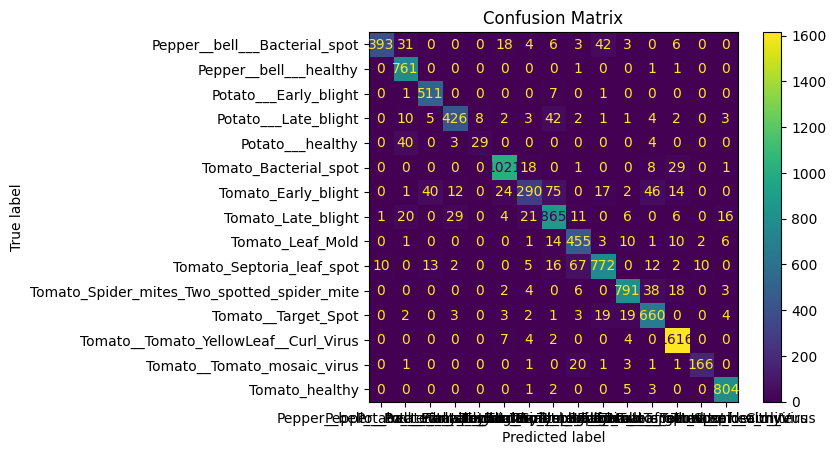

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# @markdown Get true labels and predicted labels
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# @markdown Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))

# @markdown Plot the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes).plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# @markdown Load the test dataset
reload_test_data = False # @param {type:"boolean"}
if (reload_test_data):
    test_dataset = datasets.ImageFolder(test_dir, transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

# @markdown Define a function to compute GradCAM
def compute_gradcam(input_image, target_class):
    model.eval()
    input_image = input_image.to(device)
    target_class = torch.tensor(target_class).to(device)

    # @markdown Create a GradCAM object
    gradcam = captum_attr.GuidedGradCam(model, model.inception_net_v3.Mixed_7c.branch_pool.conv)

    # @markdown Compute attribution scores
    attribution = gradcam.attribute(input_image, target=target_class)

    # @markdown Detach the attribution tensor from the computation graph
    attribution = attribution.detach()

    return attribution

# @markdown Choose an image and target class index for GradCAM visualization
image_no_for_input = 420 # @param {type:"integer"}
image, label = test_dataset[image_no_for_input]

# @markdown Transpose the image to [channels, height, width]
#image = image.permute(1, 2, 0)

def norm_(img):
    out = (img - img.min())/(img.max() - img.min())
    return out

# @markdown Compute GradCAM
attribution = compute_gradcam(image.unsqueeze(0), label)
# normalized_attribution = (attribution - attribution.min())/(attribution.max() - attribution.min())

# @markdown Visualize the GradCAM heatmap
plt.figure(figsize=(8, 8))
plt.imshow(norm_(attribution).squeeze(0).permute(1, 2, 0).cpu(), cmap='viridis')
plt.title('GradCAM Heatmap')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

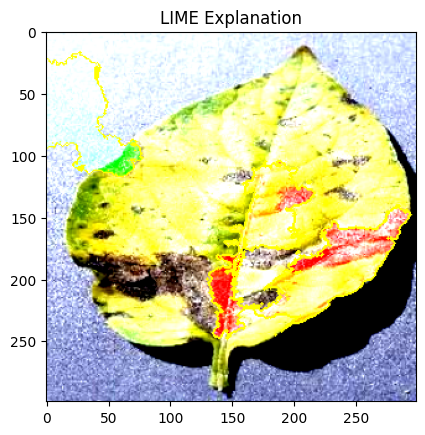

In [ ]:
# @markdown Define a function to create a Lime explainer and explain predictions
"""
# @markdown &emsp;Now we are ready to define classification function that Lime needs.\
# @markdown &emsp;The input to this function is numpy array of images where each image is ndarray \
# @markdown &emsp;of shape (channel, height, width). The output is numpy aaray of shape \
# @markdown &emsp;(image index, classes) where each value in array should be probability for that \
# @markdown &emsp;image, class combination.
"""
preprocess_transform = transforms.Compose([
    transforms.Resize((dim, dim)),  # Resize images to a fixed size
    transforms.CenterCrop(crop_dim),     # Center crop to crop_dim * crop_dim pixels
    transforms.Normalize(mean=norm_mean, std=norm_std)  # Normalize
])
def batch_predict(images):
    model.eval()
    if len(images.shape) > 3: batch = torch.stack([preprocess_transform(torch.from_numpy(i).permute(2, 0, 1)) for i in images], dim=0)
    else: batch = preprocess_transform(torch.from_numpy(i)).permute(2, 0, 1).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

def explain_lime(image, model, num_classes):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, model, top_labels = num_classes)
    return explanation

# @markdown Choose an image to explain
image_no_for_input = 420 # @param {type:"integer"}
image, label = test_dataset[image_no_for_input]
explanation = explain_lime(image.permute(1, 2, 0).numpy(), batch_predict, num_classes)

# @markdown Visualize the Lime explanation
temp, mask = explanation.get_image_and_mask(
                                            label,
                                            positive_only=False,
                                            num_features=5,
                                            hide_rest=False
                                            )

plt.imshow(mark_boundaries(norm_(temp) / 2 + 0.5, mask), cmap='viridis')
plt.title('LIME Explanation')
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


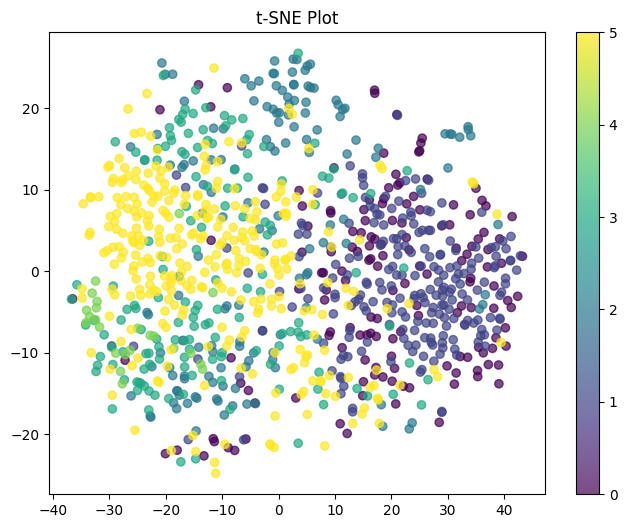

In [ ]:
# @markdown Get feature representations for a subset of your data
num_samples = 1000  # @param {type:"integer"}
features = []
labels = []

model.eval()
with torch.no_grad():
    for inputs, batch_labels in test_loader:
        inputs = inputs.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        labels.extend(batch_labels.cpu().numpy())

features = features[:num_samples]
labels = labels[:num_samples]

# @markdown Perform t-SNE
feat = np.stack(features)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(feat)

# @markdown Visualize t-SNE plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('t-SNE Plot')
plt.show()
